In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
import shap
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

import sys
sys.path.insert(1, r"C:\Users\GHarrison\OneDrive - Lincoln College\Python Projects\Data Science\Utilities")
from classification_tools import plot_confusion_matrix
from misc_tools import percentage_bar_chart, get_shap_values

In [2]:
shap.initjs() 

https://www.analyticsvidhya.com/blog/2017/08/catboost-automated-categorical-data/

https://medium.com/analytics-vidhya/combining-scikit-learn-pipelines-with-catboost-and-dask-part-2-9240242966a7

In [7]:
df_loans = pd.read_excel("Data/CustomerLoans v3.xlsx")
df_loans.head()

,CustomerGender,CustomerAccessedAdvice,CustomerAgeAtStart,CustomerJobTitle,CustomerDepartment,CustomerDeprivationDecile,CustomerIncomeDecile,CustomerEmploymentDecile,CustomerEducationandSkillsDecile,CustomerCrimeDecile,EmployerName,EmployerBusinessActivity,EmployerNumberOfEmployees,LoanApplicationMethod,LoanType,LoanStartMonth,LoanStatus
0,F,N,52,Higher Education Lecturer,Human Resources,8,6,5,5,9,"Wilkinson, Evans and Smith",Healthcare,8000,Online,Bronze,12,Repaid
1,M,N,31,Engineer (Site),Finance,6,5,4,4,7,Evans-Taylor,Electrical Installations,18,In Person,Platinum,9,Defaulted
2,F,N,36,Warden / Ranger,Human Resources,2,2,1,1,7,Williams LLC,"Business, Consulting and Management",1800,Online,Platinum,5,Repaid
3,F,N,51,Dispensing Optician,Human Resources,2,2,2,2,4,"Wilkinson, Evans and Smith",Healthcare,8000,Online,Silver,1,Defaulted
4,F,N,37,Higher Education Lecturer,Human Resources,10,9,8,7,10,Lewis Group,Teaching and Education,738,Online,Bronze,9,Repaid


In [4]:
df_loans["LoanStatus"].value_counts()

Repaid       2727
Defaulted    1452
Live         1107
Name: LoanStatus, dtype: int64

In [5]:
df_loans.drop(["CustomerNumber", "CustomerForename", "CustomerSurname", "CustomerPostcode"], axis=1, inplace=True)
df_loans.drop(["LoanStartYear", "LoanExpectedEndYear", "LoanActualEndYear"], axis=1, inplace=True)

df_loans = df_loans.dropna()

cat_type : str = "category"
int_type : str = "int64"    

df_loans = df_loans.astype({"CustomerGender" : cat_type, "CustomerAccessedAdvice" : cat_type, "CustomerJobTitle" : cat_type, "CustomerDepartment" : cat_type, "EmployerBusinessActivity" : cat_type, "EmployerName" : cat_type, "LoanApplicationMethod" : cat_type, "LoanType" : cat_type, "LoanStatus" : cat_type})
df_loans = df_loans.astype({"CustomerAgeAtStart" : int_type, "CustomerDeprivationDecile" : int_type, "CustomerIncomeDecile" : int_type, "CustomerEmploymentDecile" : int_type, "CustomerEducationandSkillsDecile" : int_type, "CustomerCrimeDecile" : int_type, "EmployerNumberOfEmployees" : int_type, "LoanStartMonth" : int_type})

df_loans["LoanStatus"] = np.where(df_loans["LoanStatus"] == "Live", np.nan, df_loans["LoanStatus"])

In [6]:
df_loans.to_excel("Data/CustomerLoans v3.xlsx", index=False)

In [ ]:
df_loans = pd.get_dummies(df_loans, columns=["CustomerGender", "CustomerAccessedAdvice", "CustomerJobTitle", "CustomerDepartment", "EmployerName", "EmployerBusinessActivity", "LoanApplicationMethod", "LoanType"])
df_loans.rename(columns = lambda x:re.sub('[^A-Za-z0-9-]+', '', x), inplace=True) # Remove special characters from feature names to resolve "LightGBMError: Do not support special JSON characters in feature name." error

In [65]:
df_loans.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5260 entries, 0 to 5285
Data columns (total 2164 columns):
 #     Column                                                   Dtype 
---    ------                                                   ----- 
 0     CustomerAgeAtStart                                       int64 
 1     CustomerDeprivationDecile                                int64 
 2     CustomerIncomeDecile                                     int64 
 3     CustomerEmploymentDecile                                 int64 
 4     CustomerEducationandSkillsDecile                         int64 
 5     CustomerCrimeDecile                                      int64 
 6     EmployerNumberOfEmployees                                int64 
 7     LoanStatus                                               object
 8     LoanStartMonth                                           int64 
 9     CustomerGenderF                                          uint8 
 10    CustomerGenderM                 

In [66]:
completed_filter = df_loans["LoanStatus"].isin(["Repaid", "Defaulted"])
df_completed = df_loans[completed_filter].copy(deep=True)
df_live = df_loans[~completed_filter].copy(deep=True)

In [67]:
df_completed["LoanStatus"].value_counts(normalize=True)

Repaid       0.652069
Defaulted    0.347931
Name: LoanStatus, dtype: float64

In [68]:
X = df_completed.drop(["LoanStatus"], axis=1)
y = df_completed["LoanStatus"]#.map({"Defaulted" : 1, "Repaid" : 0}).astype("int64")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [69]:
X_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3117 entries, 3029 to 962
Data columns (total 2163 columns):
 #     Column                                                   Dtype
---    ------                                                   -----
 0     CustomerAgeAtStart                                       int64
 1     CustomerDeprivationDecile                                int64
 2     CustomerIncomeDecile                                     int64
 3     CustomerEmploymentDecile                                 int64
 4     CustomerEducationandSkillsDecile                         int64
 5     CustomerCrimeDecile                                      int64
 6     EmployerNumberOfEmployees                                int64
 7     LoanStartMonth                                           int64
 8     CustomerGenderF                                          uint8
 9     CustomerGenderM                                          uint8
 10    CustomerAccessedAdviceN                   

In [70]:
#categorical_features = np.where(X_train.dtypes == "category")[0]
model = LGBMClassifier(random_state=42)

#categorical_features = list(X_train.select_dtypes(include=["category"]).columns)
#categorical_features

model.fit(X_train, y_train)#, categorical_feature=categorical_features)

LGBMClassifier(random_state=42)

In [11]:
#model = CatBoostClassifier(random_state=42)
#categorical_features_indices = np.where(X_train.dtypes == "string")[0]
#model.fit(X_train.to_numpy(), y_train.to_numpy(), cat_features=categorical_features_indices, eval_set=(X_test.to_numpy(), y_test.to_numpy()), plot=True)

In [71]:
y_test_pred = model.predict(X_test)
y_test_pred

array(['Defaulted', 'Repaid', 'Repaid', ..., 'Repaid', 'Repaid',
       'Defaulted'], dtype=object)

In [72]:
accuracy_score(y_test, y_test_pred)

0.7045235803657363

In [73]:
explainer, shap_values = get_shap_values(model, X_train, X_test)

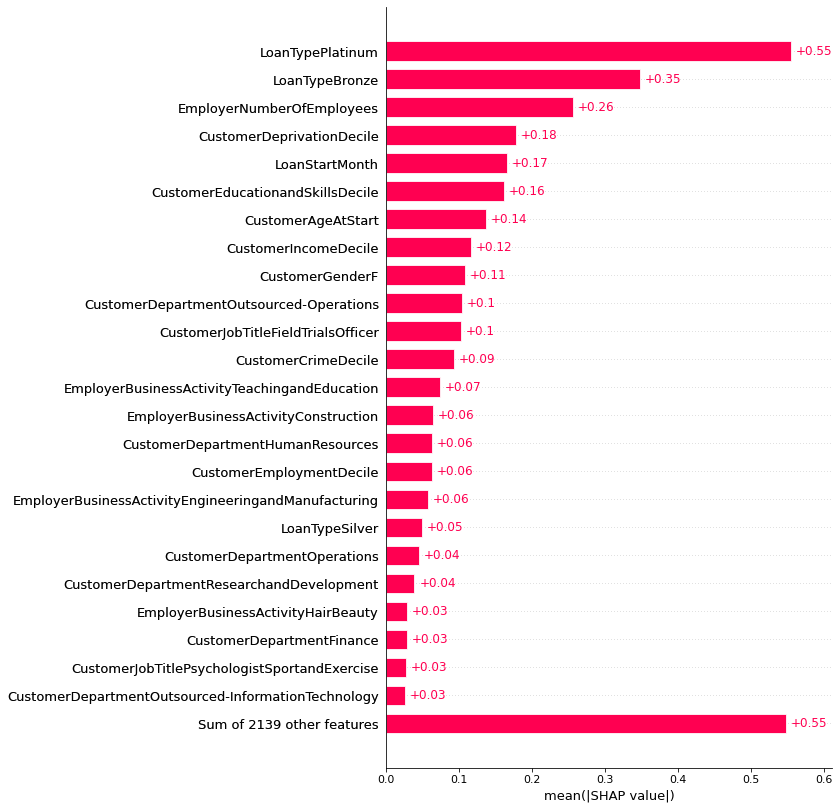

In [74]:
shap.plots.bar(shap_values, max_display=25) # Display the most important features used by the training model to explain the test / production model

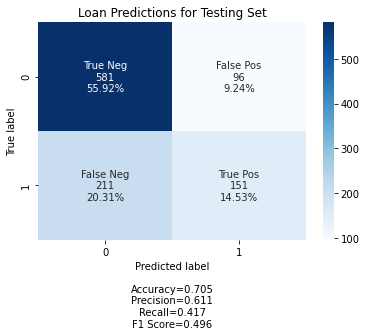

In [75]:
plot_confusion_matrix(y_test, y_test_pred, labels=["Repaid", "Defaulted"], title=f"Loan Predictions for Testing Set", cmap="Blues")

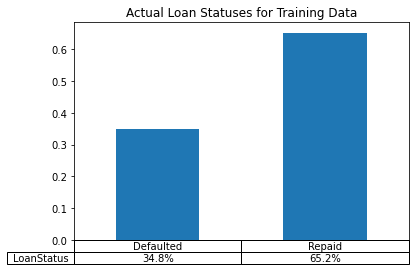

In [77]:
percentage_bar_chart(y_train, title="Actual Loan Statuses for Training Data")

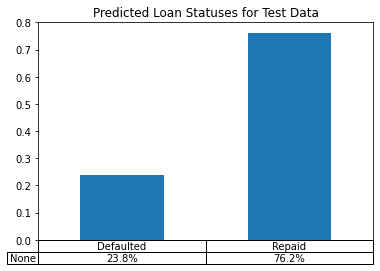

In [78]:
percentage_bar_chart(pd.Series(y_test_pred), title="Predicted Loan Statuses for Test Data")

In [79]:
y_live_pred = model.predict(df_live.drop(["LoanStatus"], axis=1))

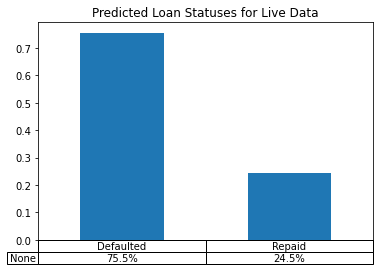

In [80]:
percentage_bar_chart(pd.Series(y_live_pred), title="Predicted Loan Statuses for Live Data")

In [81]:
df_live["LoanTypePlatinum"].value_counts(normalize=True).sort_index()

0    0.05163
1    0.94837
Name: LoanTypePlatinum, dtype: float64

In [82]:
X_train["LoanTypePlatinum"].value_counts(normalize=True).sort_index()

0    0.770934
1    0.229066
Name: LoanTypePlatinum, dtype: float64